In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

import pandas as pd
import statsmodels.api as sm
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from Oceanmodel.engine import create_par_sweep, system_params

In [ ]:
# read csv files to df
# two parts because two batches
simulation_result = pd.DataFrame()
file_prefix = 'first_big_sim_batch_'

batches = 90
batch_size = 3

for i in range(batches):
    df = pd.read_csv('results/' + file_prefix + str(i) + '.csv')
    df['subset'] = df['subset'] + i * batch_size

    simulation_result = pd.concat([simulation_result, df])
    
file_prefix = 'first_big_sim_batch_small_'
batches = 324
batches_start = 271
batch_size = 1

for i in range(batches_start, batches):
    df = pd.read_csv('results/' + file_prefix + str(i) + '.csv')
    df['subset'] = df['subset'] + i * batch_size

    simulation_result = pd.concat([simulation_result, df])

In [ ]:
simulation_result.groupby(['simulation', 'subset']).count()['timestep']

simulation  subset
0           0         832
            1         832
            2         832
            3         832
            4         832
                     ... 
            319       832
            320       832
            321       832
            322       832
            323       832
Name: timestep, Length: 323, dtype: int64

In [2]:
simulation_result = pd.DataFrame()
file_prefix = 'second_big_sim_parambatch_'

batches = 36
batch_size = 2
psub_count = 4

for i in range(psub_count):
    for j in range(batches):
        df = pd.read_csv('results/second_big_sim/' + file_prefix +str(j)+'psubsbatch_'+str(i)+'.csv')
        df['subset'] = df['subset'] + j * batch_size + batch_size * batches * i
        simulation_result = pd.concat([simulation_result, df])

import re
def extract_decimal(x):
    if type(x) == float:
        return x
    else:
        match = re.search(r'\d+\.\d+', x)
        if match:
            return float(match.group())
        else:
            return float(0.0)
    
simulation_result.active_pct = simulation_result.active_pct.apply(extract_decimal)
simulation_result.Active_APY = simulation_result.Active_APY.apply(extract_decimal)
simulation_result.Agg_APY = simulation_result.Agg_APY.apply(extract_decimal)


In [3]:
simulation_result.groupby(['simulation', 'subset']).count()['timestep']

simulation  subset
0           0         832
            1         832
            2         832
            3         832
            4         832
                     ... 
            283       832
            284       832
            285       832
            286       832
            287       832
Name: timestep, Length: 288, dtype: int64

In [3]:
# recreate system_params
system_params = create_par_sweep(system_params)

In [10]:
# Agg APY was missing in post-processing for first_big_sim
simulation_result['Agg_APY'] = simulation_result.apply(lambda x: (x['Passive_APY'] + x['Fees_APY'] + x['Active_APY']*x['active_pct']), axis=1)

In [4]:
# success = true, failure = false
# success if Agg_APY stays above the threshold X% for more than Y% of the timesteps

df_kpi_1 = simulation_result.groupby(['subset']).apply(lambda x: (x.Agg_APY > 0.05).mean() > 0.7).reset_index(name='agg_apy_kpi')
df_kpi_2 = simulation_result.groupby(['subset']).apply(lambda x: (x.Active_APY > 0.1).mean() > 0.7).reset_index(name='active_apy_threshold')
df_kpi_3 = df_kpi_1.merge(df_kpi_2, on='subset').apply(lambda x: (x.agg_apy_kpi == True == x.active_apy_threshold), axis=1).reset_index(name='curation_kpi')
#??? low active APY means failing to incentivize curation ??? df_kpi_3 = simulation_result.groupby(['subset']).apply(lambda x: (x.active_apy > 0.075).mean() > 0.7).reset_index(name='agg_apy_threshold_2')

df_kpis = pd.concat([df_kpi_1, df_kpi_3.curation_kpi], axis=1)
df_kpis

,subset,agg_apy_kpi,curation_kpi
0,0,True,True
1,1,True,True
2,2,True,False
3,3,True,False
4,4,True,False
...,...,...,...
283,283,False,False
284,284,False,False
285,285,False,False
286,286,False,False


In [10]:
df_kpis.groupby('agg_apy_kpi').count()['subset']

agg_apy_kpi
False    126
True     162
Name: subset, dtype: int64

In [5]:
#def get_min_lock_dur_column(x, batch_size, batches, params_nested_dict):
#    for i in range(len(params_nested_dict)):
#        if batch_size*batches*i <= x < batch_size*batches*(i+1):
#            return params_nested_dict[i]['min_lock']

#def get_max_lock_dur_column(x, batch_size, batches, params_nested_dict):
#    for i in range(len(params_nested_dict)):
#         if batch_size*batches*i <= x < batch_size*batches*(i+1):
#             return params_nested_dict[i]['max_lock']

# for every row of df_kpi, join column='key' with values system_params[key][x['subset']] 
for key in system_params.keys():
    if key == 'lock_dur':
        #params_column_1 = df_kpis['subset'].apply(lambda x: get_min_lock_dur_column(x, batch_size, batches, system_params[key])).rename('min_lock_dur')
        params_column = df_kpis['subset'].apply(lambda x: system_params[key][x%(batch_size*batches)]['min_lock']).rename('min_lock_extracted')
        df_kpis = pd.concat([df_kpis, params_column], axis=1)
        #params_column_2 = df_kpis['subset'].apply(lambda x: get_max_lock_dur_column(x, batch_size, batches, system_params[key])).rename('max_lock_dur')
        params_column = df_kpis['subset'].apply(lambda x: system_params[key][x%(batch_size*batches)]['max_lock']).rename('max_lock_extracted')
        df_kpis = pd.concat([df_kpis, params_column], axis=1)

        df_kpis['lock_dur_param'] = df_kpis['min_lock_extracted'].astype(str) + '-' + df_kpis['max_lock_extracted'].astype(str)
        lock_dur_param_map = {'1-208': 0, '1-104': 1, '52-156':2, '104-208': 3}
        df_kpis['lock_duration_assumption'] = df_kpis['lock_dur_param'].map(lock_dur_param_map)
    else:
        params_column = df_kpis['subset'].apply(lambda x: system_params[key][x%(batch_size*batches)]).rename(key)
        df_kpis = pd.concat([df_kpis, params_column], axis=1)
        
def get_psub_column(x, batch_size, batches):#, psub):
    if (batch_size * batches * 0) <= x < batch_size * batches * (0 + 1):
        return 0
    elif (batch_size * batches * 1) <= x < batch_size * batches * (1 + 1):
        return 1
    elif (batch_size * batches * 2) <= x < batch_size * batches * (2 + 1):
        return 2
    elif (batch_size * batches * 3) <= x < batch_size * batches * (3 + 1):
        return 3
    else:
        return 99
    
# create a new column for each psub where the value is 1 if the subset was part of the psub and 0 otherwise
#for psub in range(psub_count):
#    psub_map = {0:'vote_U_dcv_U', 1:'vote_U_dcv_P', 2:'vote_P_dcv_U', 3:'vote_P_dcv_P'}
#    psub_column = df_kpis['subset'].apply(lambda x: get_psub_column(x, batch_size, batches, psub)).rename(f'psub_{psub_map[psub]}')
#    df_kpis = pd.concat([df_kpis, psub_column], axis=1)
psub_map = {0:'vote_U_dcv_U', 1:'vote_U_dcv_P', 2:'vote_P_dcv_U', 3:'vote_P_dcv_P'}
psub_column = df_kpis['subset'].apply(lambda x: get_psub_column(x, batch_size, batches)).rename(f'psub_assumption')
df_kpis = pd.concat([df_kpis, psub_column], axis=1)



df_kpis

,subset,agg_apy_kpi,curation_kpi,minlock_amt,maxlock_amt,min_lock_extracted,max_lock_extracted,lock_dur_param,lock_duration_assumption,minlock_dur,...,datafarming_max_assets_n,datafarming_weekly_yield_cap,datafarming_apy_cap,protocol_revenue_community_share,protocol_transaction_fee,revenue_burn_pct,dcv_growth_rate,min_accepted_yield,lock_supply_pct_cap,psub_assumption
0,0,True,True,10000.0,5000000.0,1,208,1-208,0,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,0
1,1,True,True,10000.0,5000000.0,1,208,1-208,0,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,0
2,2,True,False,10000.0,5000000.0,1,208,1-208,0,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,0
3,3,True,False,10000.0,5000000.0,1,208,1-208,0,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,0
4,4,True,False,10000.0,5000000.0,1,208,1-208,0,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,283,False,False,10000.0,5000000.0,104,208,104-208,3,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,3
284,284,False,False,10000.0,5000000.0,104,208,104-208,3,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,3
285,285,False,False,10000.0,5000000.0,104,208,104-208,3,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,3
286,286,False,False,10000.0,5000000.0,104,208,104-208,3,1,...,100,0.015717,1.25,0.5,0.001,0.5,0.1,0.0,0.85,3


In [6]:
def analyze_success(X, Y, name):
    print("-"*50)
    print("KPI: {}".format(name))
    print("-"*50)
    print()
    print()
    # Fit model
    model = sm.Logit(Y, X).fit()
    
    # Find predictors
    predictors = pd.concat([model.params, model.pvalues], axis=1)
    predictors.columns = ['coef', 'p-value']
    predictors = predictors.drop(index='const')
    predictors = predictors[predictors['p-value'] < .05]
    print("Statistically Significant Predictors (Logistic Regression):")
    print(predictors)
    print()
    print()
    
    fig, axes = plt.subplots(nrows=2,
                             figsize=(10, 8),
                             gridspec_kw={'height_ratios': [3, 1]})

    model = DecisionTreeClassifier(max_depth=3)
    rf = RandomForestClassifier(max_depth=6)
    model.fit(X, Y)
    rf.fit(X, Y)

    importance = (pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)),
                           columns=['features', 'importance'])
              .sort_values(by='importance', ascending=False)
              )

    plot_tree(model,
                  rounded=True,
                  proportion=True,
                  fontsize=8,
                  feature_names=list(X.columns),
                  class_names=['Failure', 'Success'],
                  filled=True,
                  ax=axes[0])

    axes[0].set_title(
            f'Decision tree, score: {model.score(X, Y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(data=importance,
                    x=importance.features,
                    y=importance.importance,
                    ax=axes[1],
                    label='small')
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
    axes[1].set_title(f'Feature Importance')

    plt.show()
    
    print()
    print()
    
    variables = [a for a in X.columns if a != "const"]
    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15,10))
    for i, var in enumerate(variables):
        ax = axs[i // 3, i%3]
        sns.kdeplot(df_kpis, x=var, hue=y, ax=ax, common_norm=False,
                   common_grid=False)
        ax.set_title("{} KDE by Success".format(var))
    plt.show()
    
    for _ in range(20):
        print()

In [7]:
df_kpis.columns

Index(['subset', 'agg_apy_kpi', 'curation_kpi', 'minlock_amt', 'maxlock_amt',
       'min_lock_extracted', 'max_lock_extracted', 'lock_dur_param',
       'lock_duration_assumption', 'minlock_dur', 'maxlock_dur',
       'min_weekly_dcv_amt', 'max_weekly_dcv_amt', 'weekly_lock_prob',
       'weekly_vote_success_prob', 'weekly_consume_prob',
       'weekly_consume_multiple', 'datafarming_active_share',
       'datafarming_max_assets_n', 'datafarming_weekly_yield_cap',
       'datafarming_apy_cap', 'protocol_revenue_community_share',
       'protocol_transaction_fee', 'revenue_burn_pct', 'dcv_growth_rate',
       'min_accepted_yield', 'lock_supply_pct_cap', 'psub_assumption'],
      dtype='object')

--------------------------------------------------
KPI: agg_apy_kpi
--------------------------------------------------


Optimization terminated successfully.
         Current function value: 0.498866
         Iterations 6
Statistically Significant Predictors (Logistic Regression):
                              coef       p-value
lock_duration_assumption -0.618892  5.503360e-05
weekly_lock_prob         -1.394533  2.395279e-16




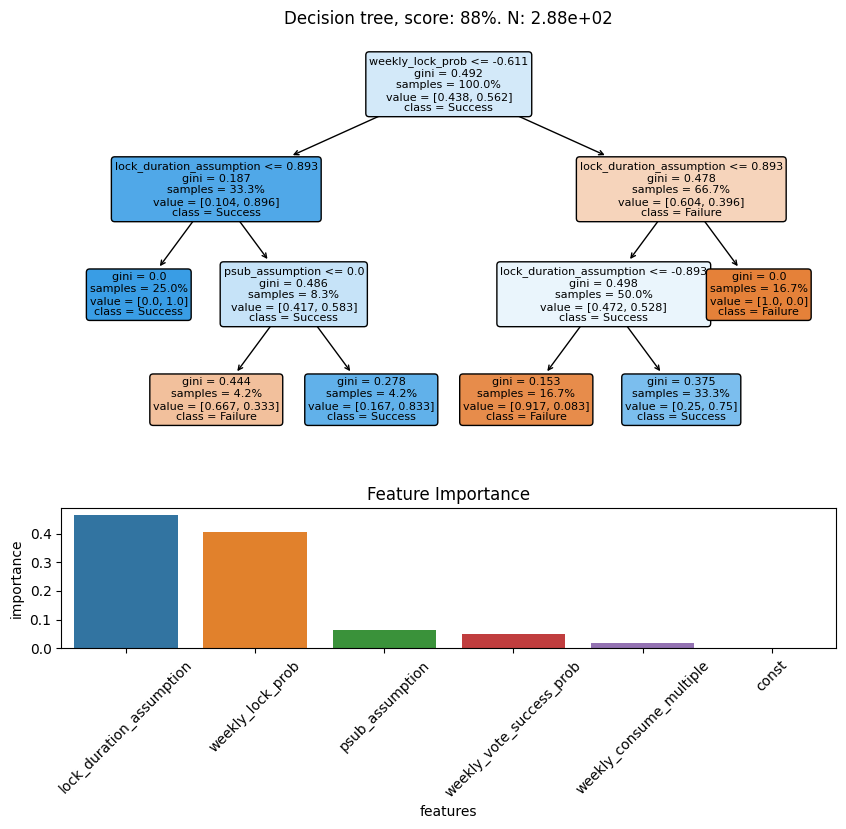

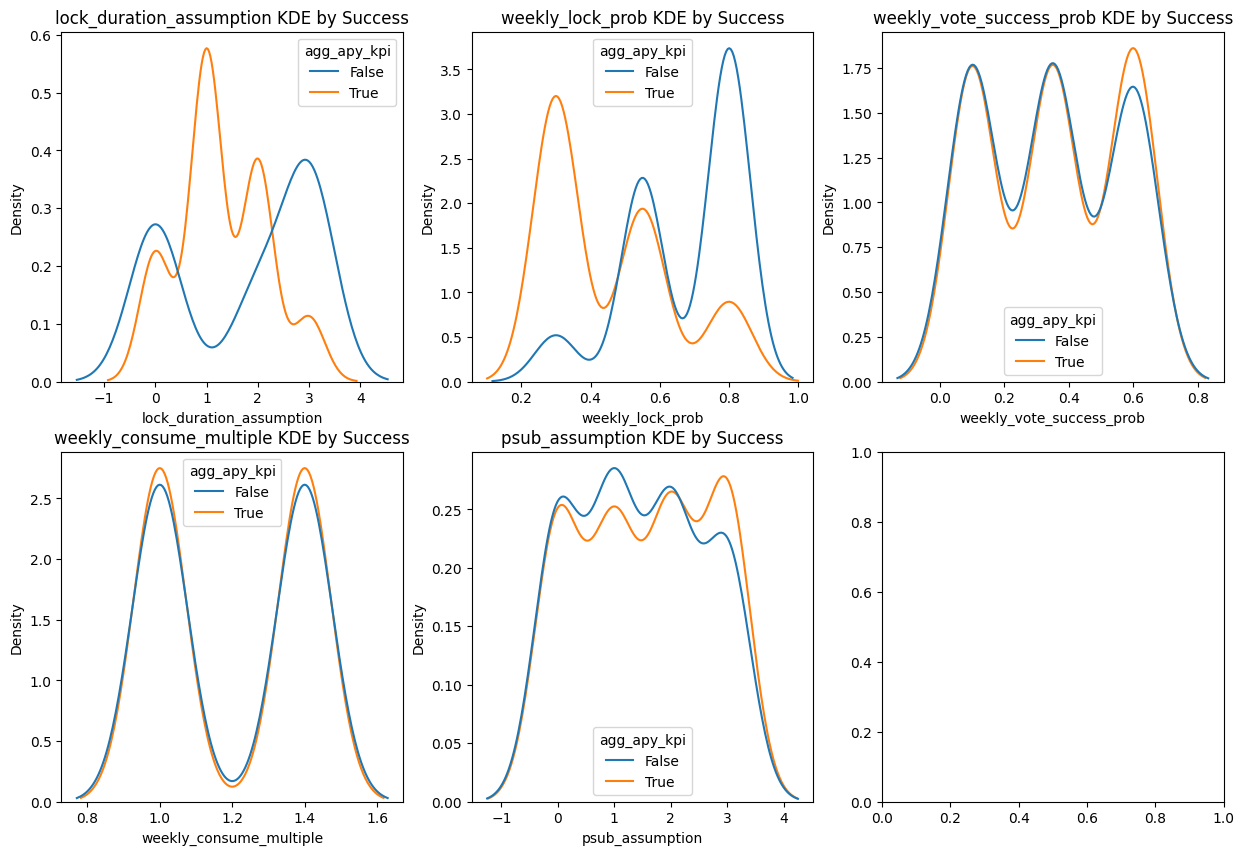





















--------------------------------------------------
KPI: curation_kpi
--------------------------------------------------


Optimization terminated successfully.
         Current function value: 0.504552
         Iterations 6
Statistically Significant Predictors (Logistic Regression):
                              coef       p-value
lock_duration_assumption -0.514930  5.596852e-04
weekly_lock_prob         -0.924906  4.949699e-09
weekly_vote_success_prob -0.902868  1.005764e-08




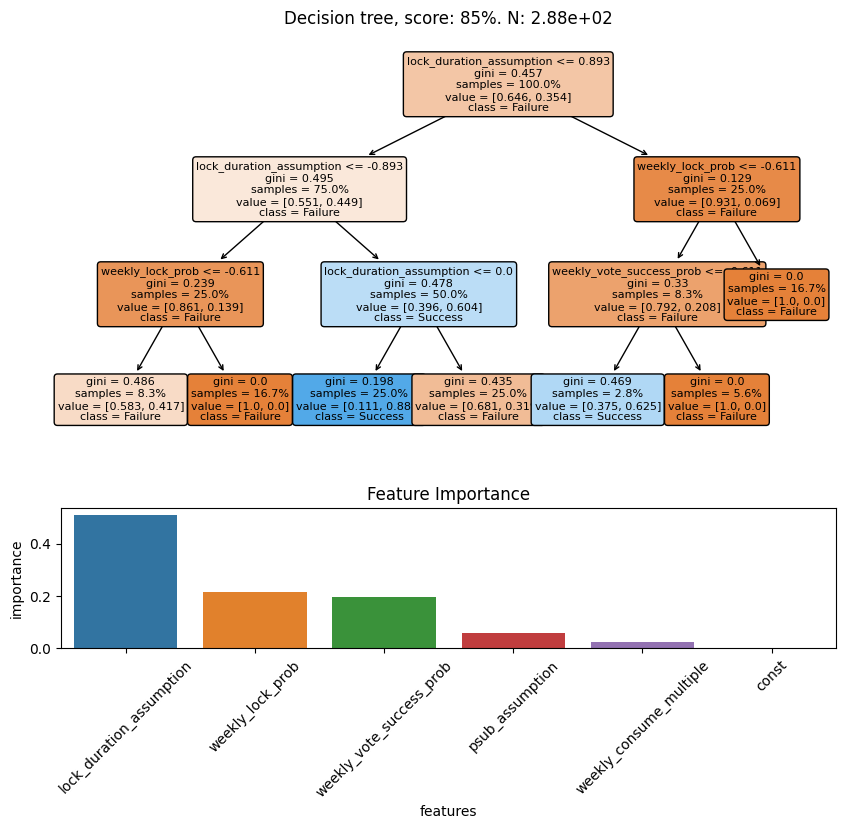

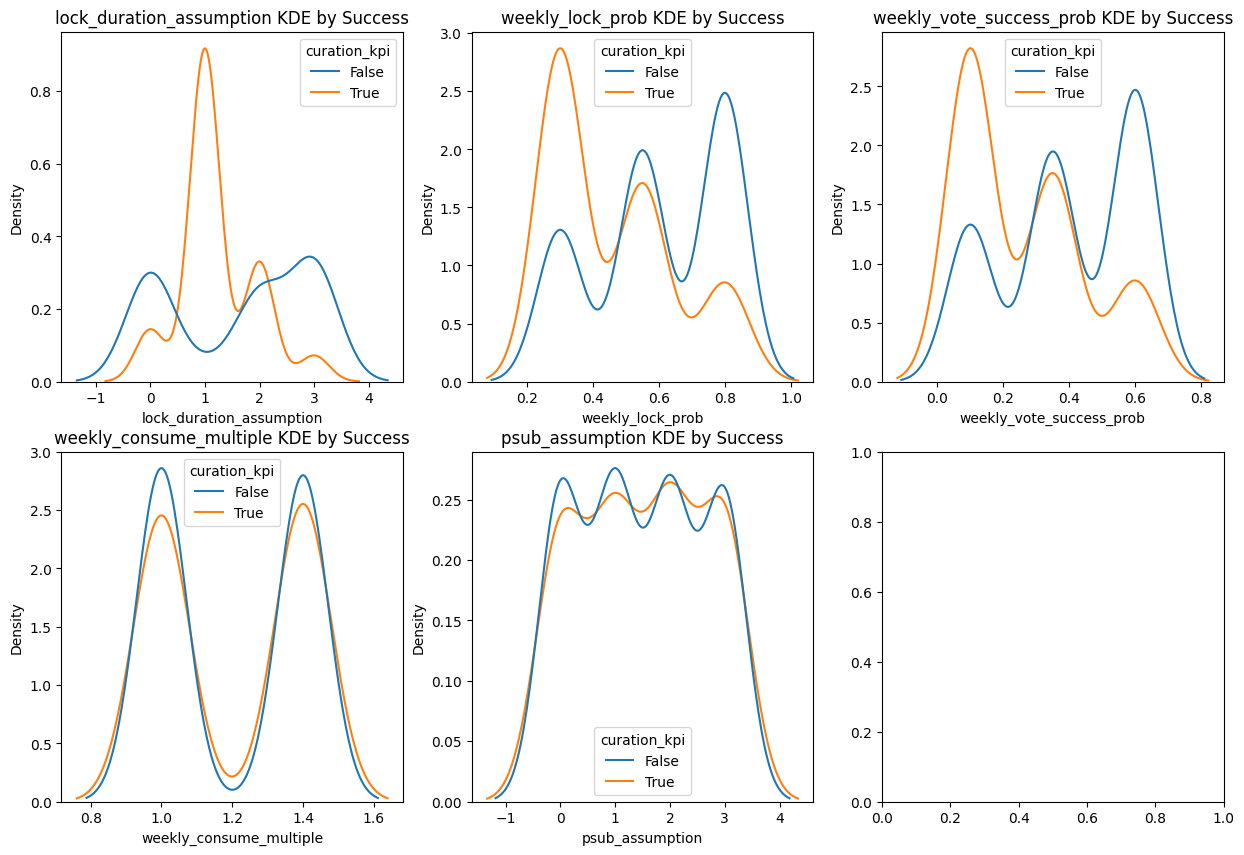

In [8]:

#X = df_kpis[['weekly_lock_prob','weekly_vote_success_prob','weekly_consume_multiple']]
X = df_kpis[['lock_duration_assumption', 'weekly_lock_prob', 'weekly_vote_success_prob'
            , 'weekly_consume_multiple', 'psub_assumption']]

# Scale to standard normal
X = (X - X.mean()) / X.std()
X['const'] = 1

for y in ['agg_apy_kpi', 'curation_kpi']:
    Y = df_kpis[y]
    analyze_success(X, Y, y)